# MovieLens
Movie Lens is a website that helps users find the movies they like and where they will rate the recommended movies. [MovieLens 1M dataset](https://grouplens.org/datasets/movielens/1m/) is a dataset including the observations collected in an online movie recommendation experiment and is widely used to generate data for online bandit simulation studies. The goal of the simulation studies below is to learn the reward distribution of different movie genres and hence to recommend the optimal movie genres to the users to optimize the cumulative user satisfaction. In other words, every time a user visits the website, the agent will recommend a movie genre ($A_t$) to the user, and then the user will give a rating ($R_t$) to the genre recommended. We assume that users' satisfaction is fully reflected through the ratings. Therefore, the ultimate goal of the bandit algorithms is to optimize the cumulative ratings received by finding and recommending the optimal movie genre that will receive the highest rating. In this tutorial, we mainly focus on the following 4 Genres, including 

- **Comedy**: $a=0$,
- **Drama**: $a=1$
- **Action**: $a=2$,
- **Thriller**: $a=3$,
- **Sci-Fi**: $a=4$.

Therefore, $K=5$. For each user, feature information, including age, gender and occupation, are available:

- **age**: numerical, from 18 to 56,
- **gender**: binary, =1 if male,
- **college/grad student**: binary, =1 if a college/grad student,
- **executive/managerial**: binary, =1 if a executive/managerial,
- **technician/engineer**: binary, =1 if a technician/engineer,
- **other**: binary, =1 if having other occupations other than the rest of the four occupations,
- **academic/educator**: if an academic/educator, then all the previous occupation-related variables = 0 (baseline).

The realized reward $R_t$ is a numerical variable, taking the value of $\{1,2,3,4,5\}$,with 1 being the least satisfied and 5 being the most satisfied. In the following, we first perform causal effect learning on the logged data and output the estimated reward for each movie genre. Then, we conduct online learning to efficiently explore the optimal policy utilizing both the estimation results and new information collected through real-time online iteraction.

## Causal Effect Learning

In [1]:
import os
os.getcwd()
path = 'D:/Github/CausalDM'
os.chdir(path)
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from causaldm.learners.Online.CMAB import _env_realCMAB as _env
from causaldm.learners.Online.CMAB import LinTS
env = _env.Single_Contextual_Env(seed = 0, Binary = False)
logged_data, arms = env.get_logged_dat()

ModuleNotFoundError: No module named 'causaldm.learners.Online'

In [3]:
logged_data.keys()

dict_keys(['Comedy', 'Drama', 'Action', 'Thriller', 'Sci-Fi'])

In [4]:
logged_data['Comedy']

,user_id,movie_id,rating,age,Comedy,Drama,Action,Thriller,Sci-Fi,gender_M,occupation_academic/educator,occupation_college/grad student,occupation_executive/managerial,occupation_other,occupation_technician/engineer
685706,48,2042.0,2.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
499683,48,2424.0,4.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
694860,53,330.0,3.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
207691,169,3671.0,4.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
425839,169,3869.0,3.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213638,4140.0,153.0,2.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
242271,4140.0,435.0,1.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
717322,4411,910.0,5.0,18.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
345927,4411.0,45.0,2.0,18.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [5]:
userinfo_index = np.array([3,9,11,12,13,14])
movie_generes = ['Comedy', 'Drama', 'Action', 'Thriller', 'Sci-Fi']

In [6]:
# convert the sampled dataset of interest to dataframe format
data_CEL_sample = logged_data['Comedy']
for movie_genere in movie_generes[1:5]:
    data_CEL_sample = pd.concat([data_CEL_sample, logged_data[movie_genere]])

In [7]:
len(data_CEL_sample) # the total sample size we selected: n=1286

1286

### nonlinear model fitting

In [8]:
models_CEL = {}
 
# initialize the models we'll fit in Causal Effect Learning
for i in movie_generes:
    models_CEL[i] = None   
from lightgbm import LGBMRegressor
for movie_genere in movie_generes: 
    models_CEL[movie_genere] = LGBMRegressor(max_depth=3)
    models_CEL[movie_genere].fit(data_CEL_sample.iloc[np.where(data_CEL_sample[movie_genere]==1)[0],userinfo_index],data_CEL_sample.iloc[np.where(data_CEL_sample[movie_genere]==1)[0],2] )


In [9]:
# record thev estimated expected reward for each movie genere, under each possible combination of state variable
age_range = np.linspace(min(data_CEL_sample['age']),max(data_CEL_sample['age']),int(max(data_CEL_sample['age'])-min(data_CEL_sample['age'])+1)).astype(int)

In [10]:
import itertools

gender = np.array([0,1])
occupation_college = np.array([0,1])
occupation_executive = np.array([0,1])
occupation_other  = np.array([0,1])
occupation_technician = np.array([0,1])

# result contains all possible combinations.
combinations = pd.DataFrame(itertools.product(age_range,gender,occupation_college,
                                              occupation_executive,occupation_other,occupation_technician))
combinations.columns =['age','gender','occupation_college', 'occupation_executive','occupation_other','occupation_technician']

In [11]:
models_CEL['Comedy'].predict(combinations)
#models_CEL['Comedy'].predict(data_CEL_sample.iloc[np.where(data_CEL_sample['Comedy']==1)[0],userinfo_index])

array([3.1224, 3.0439, 3.7664, ..., 3.5822, 3.6663, 3.6364])

In [12]:
values = np.zeros((5,1312))
i=0
for movie_genere in movie_generes:
    values[i,:] = models_CEL[movie_genere].predict(combinations)
    i=i+1
    #print(values)

In [13]:
result_CEL_nonlinear = combinations.copy()
i=0
for movie_genere in movie_generes:
    #values = models_CEL[movie_genere].predict(combinations)
    result_CEL_nonlinear.insert(len(result_CEL_nonlinear.columns), movie_genere, values[i,:])
    i=i+1

In [14]:
result_CEL_nonlinear

,age,gender,occupation_college,occupation_executive,occupation_other,occupation_technician,Comedy,Drama,Action,Thriller,Sci-Fi
0,16,0,0,0,0,0,3.122379,3.576471,3.066448,3.583382,3.133766
1,16,0,0,0,0,1,3.043862,3.205939,3.232727,3.583382,3.133766
2,16,0,0,0,1,0,3.766441,3.910281,3.336623,3.717603,3.160268
3,16,0,0,0,1,1,3.687924,3.331463,3.345233,3.717603,3.160268
4,16,0,0,1,0,0,3.377340,3.649888,3.039056,3.923635,3.133766
...,...,...,...,...,...,...,...,...,...,...,...
1307,56,1,1,0,1,1,3.297553,3.090110,3.024221,3.658442,3.151436
1308,56,1,1,1,0,0,3.612166,3.695911,3.608458,3.740830,3.151436
1309,56,1,1,1,0,1,3.582210,3.165707,3.552889,3.740830,3.151436
1310,56,1,1,1,1,0,3.666311,3.283311,3.129195,3.740830,3.151436


In [14]:
# save the result to
path += '/5_Case_Study/MovieLens'
result_CEL_nonlinear.to_csv(path+'/result_CEL_nonlinear.csv')

OSError: Cannot save file into a non-existent directory: '/nas/longleaf/home/lge/CausalDM/5_Case_Study/MovieLens'

In [15]:
# read the result file
result_CEL_nonlinear = pd.read_csv(path+'/result_CEL_nonlinear.csv')
result_CEL_nonlinear = result_CEL_nonlinear.drop(result_CEL_nonlinear.columns[0], axis=1)
result_CEL_nonlinear

FileNotFoundError: [Errno 2] No such file or directory: '/nas/longleaf/home/lge/CausalDM/5_Case_Study/MovieLens/result_CEL_nonlinear.csv'

#### Analysis

In [15]:
# calculate the expected reward of Comedy for female
TE_female=result_CEL_nonlinear.iloc[np.where(result_CEL_nonlinear['gender']==0)[0],6:11]/(41*(2**4))
TE_female=pd.DataFrame(TE_female.sum(axis=0))
TE_female.columns =['Expected Rating']

In [16]:
TE_female

,Expected Rating
Comedy,3.500268
Drama,3.309777
Action,3.562432
Thriller,3.605472
Sci-Fi,2.960134


In [17]:
# calculate the expected reward of Comedy for female
TE_male=result_CEL_nonlinear.iloc[np.where(result_CEL_nonlinear['gender']==1)[0],6:11]/(41*(2**4))
TE_male=pd.DataFrame(TE_male.sum(axis=0))
TE_male.columns =['Expected Rating']

In [18]:
TE_male

,Expected Rating
Comedy,3.365749
Drama,3.321332
Action,3.256846
Thriller,3.447365
Sci-Fi,2.960134


**Conclusion**: Among these five selected movie generes, `Comedy` is the most popular one that received the highest expected rating. On the contrary, the estimated rating for `Schi-Fi` is the lowest, both for males and females. In addition, the expected ratings of women are generally slightly higher than men, except for `Drama` movies where men's rating is expected to be 0.02/5 points higher than women.

### linear model fitting

In [19]:
models_CEL_linear = {}
 
# initialize the models we'll fit in Causal Effect Learning
for i in movie_generes:
    models_CEL_linear[i] = None   
    
from sklearn.linear_model import LinearRegression
for movie_genere in movie_generes: 
    models_CEL_linear[movie_genere] = LinearRegression()
    models_CEL_linear[movie_genere].fit(data_CEL_sample.iloc[np.where(data_CEL_sample[movie_genere]==1)[0],userinfo_index],data_CEL_sample.iloc[np.where(data_CEL_sample[movie_genere]==1)[0],2] )


In [20]:
import itertools

gender = np.array([0,1])
occupation_college = np.array([0,1])
occupation_executive = np.array([0,1])
occupation_other  = np.array([0,1])
occupation_technician = np.array([0,1])

# result contains all possible combinations.
combinations = pd.DataFrame(itertools.product(age_range,gender,occupation_college,
                                              occupation_executive,occupation_other,occupation_technician))
combinations.columns =['age','gender','occupation_college', 'occupation_executive','occupation_other','occupation_technician']


In [21]:
values = np.zeros((5,1312))
i=0
for movie_genere in movie_generes:
    values[i,:] = models_CEL_linear[movie_genere].predict(combinations)
    i=i+1
    #print(values)

In [22]:
result_CEL_linear = combinations
i=0
for movie_genere in movie_generes:
    #values = models_CEL[movie_genere].predict(combinations)
    result_CEL_linear.insert(len(result_CEL_linear.columns), movie_genere, values[i,:])
    i=i+1

In [47]:
# the result is saved to
result_CEL_linear.to_csv(path+'/result_CEL_linear.csv')

In [48]:
# read the result file
result_CEL_linear = pd.read_csv(path+'/result_CEL_linear.csv')
result_CEL_linear = result_CEL_linear.drop(result_CEL_linear.columns[0], axis=1)
result_CEL_linear

,age,gender,occupation_college,occupation_executive,occupation_other,occupation_technician,Comedy,Drama,Action,Thriller,Sci-Fi
0,16,0,0,0,0,0,3.323169,3.453650,3.692167,3.482883,3.357668
1,16,0,0,0,0,1,3.325782,3.098945,3.628177,3.145705,3.886814
2,16,0,0,0,1,0,3.578237,3.666234,3.464250,3.392727,3.691633
3,16,0,0,0,1,1,3.580850,3.311529,3.400261,3.055549,4.220779
4,16,0,0,1,0,0,3.530090,3.566701,3.455929,3.741310,3.570002
...,...,...,...,...,...,...,...,...,...,...,...
1307,56,1,1,0,1,1,3.494923,3.259652,2.899359,3.006980,2.469963
1308,56,1,1,1,0,0,3.444164,3.514824,2.955027,3.692742,1.819186
1309,56,1,1,1,0,1,3.446776,3.160120,2.891038,3.355564,2.348332
1310,56,1,1,1,1,0,3.699231,3.727408,2.727111,3.602585,2.153151


#### Analysis

In [49]:
# calculate the expected reward of Comedy for female
TE_female_linear=result_CEL_linear.iloc[np.where(result_CEL_linear['gender']==0)[0],6:11]/(41*(2**4))
TE_female_linear=pd.DataFrame(TE_female_linear.sum(axis=0))
TE_female_linear.columns =['Expected Rating']

In [50]:
TE_female_linear

,Expected Rating
Comedy,3.579924
Drama,3.402675
Action,3.282099
Thriller,3.511989
Sci-Fi,3.082199


In [51]:
# calculate the expected reward of Comedy for female
TE_male_linear=result_CEL_linear.iloc[np.where(result_CEL_linear['gender']==1)[0],6:11]/(41*(2**4))
TE_male_linear=pd.DataFrame(TE_male_linear.sum(axis=0))
TE_male_linear.columns =['Expected Rating']

In [52]:
TE_male_linear

,Expected Rating
Comedy,3.445089
Drama,3.423679
Action,3.073189
Thriller,3.236301
Sci-Fi,2.957766


**Conclusion**: The expected ratings obtained under linear model is generally consistent with the result under nonlinear model. 

## Online Learning

In this section, we aim to implement the contextual TS to learn the optimal policy online. Specifically, we assume that, for each arm $i$, 
$$R_t(i)\sim \mathcal{N}(\boldsymbol{s}_i^T \boldsymbol{\gamma},\sigma^2).$$

In [23]:
#import os
#os.getcwd()
#os.chdir('D:/Github/CausalDM')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from causaldm.learners.Online.CMAB import _env_realCMAB as _env
from causaldm.learners.Online.CMAB import LinTS
env = _env.Single_Contextual_Env(seed = 0, Binary = False)
K = env.K
p = env.p
logged_data, arms = env.get_logged_dat()
CEL_results = pd.read_csv(path+'/result_CEL_nonlinear.csv').iloc[:,1:]  

### Estimated $\sigma$ and $\boldsymbol{\gamma}$

Here, we estimated the $\sigma$ and $\boldsymbol{\gamma}$ based on the logged data and the estimated results obtained from the causal effect learning (CEL) step.

In [24]:
mean_error = []
for genere in arms:
    genere_dat = logged_data[genere][['age','gender_M',
           'occupation_college/grad student', 'occupation_executive/managerial',
           'occupation_other', 'occupation_technician/engineer','rating']] 
    model = LinearRegression().fit(CEL_results.iloc[:,:-5], CEL_results[genere])
    genere_error = genere_dat.rating.to_numpy() - model.predict(np.array(genere_dat.iloc[:,:-1]))
    mean_error += genere_error.tolist()
sigma = np.std(mean_error,ddof=1)

gamma = []
for genere in arms:
    model = LinearRegression().fit(CEL_results.iloc[:,:-5], CEL_results[genere])
    gamma+=[model.intercept_] + list(model.coef_)

### Run Informative TS

Here, we run an informative TS with informative prior information, including the estimated $\sigma$ and $\gamma$. Specifically, we use $\mathcal{N}(\hat{\boldsymbol{\gamma}},.05I)$ as the prior distribution of $\gamma$. In total, we ran 50 replicates, each with 5000 total steps, to get the expected performance of online learning.

In [25]:
T = 20000
S = 50
sigma1 = .3
cum_reward_informative = []
for seed in range(S):
    env = _env.Single_Contextual_Env(seed = seed, Binary = False)
    prior_theta_u = np.array(gamma)
    prior_theta_cov = sigma1*np.identity(p)
    informative_TS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_informative_t = []
    rec_action_informative_t = []
    for t in range(T):
        X, feature_info= env.get_Phi(t)
        A = informative_TS.take_action(X)
        R = env.get_reward(t,A)
        informative_TS.receive_reward(t,A,R,X)
        cum_reward_informative_t.append(R)
        rec_action_informative_t.append(A)
    cum_reward_informative_t = np.cumsum(cum_reward_informative_t)/(np.array(range(T))+1)
    cum_reward_informative.append(cum_reward_informative_t)

### Run Uninformative TS

To further show the advantages of integrating the information from a CEL step, we run an uninformative TS with uninformative prior information. Specifically, we use $\mathcal{N}(\boldsymbol{0},1000I)$ as the prior distribution of $\gamma$. In total, we ran 50 replicates, each with 5000 total steps, to get the expected performance of online learning.

In [26]:
T = 20000
S = 50
cum_reward_uninformative = []
for seed in range(S):
    env = _env.Single_Contextual_Env(seed = seed, Binary = False)
    K = env.K
    p = env.p
    prior_theta_u = np.zeros(p)
    prior_theta_cov = 1000*np.identity(p)
    uninformative_TS= LinTS.LinTS_Gaussian(sigma = sigma, prior_theta_u = prior_theta_u, 
                                                    prior_theta_cov = prior_theta_cov, 
                                                    K = K, p = p,seed = seed)
    cum_reward_uninformative_t = []
    rec_action_uninformative_t = []
    for t in range(T):
        X, feature_info = env.get_Phi(t)
        A = uninformative_TS.take_action(X)
        R = env.get_reward(t,A)
        uninformative_TS.receive_reward(t,A,R,X)
        cum_reward_uninformative_t.append(R)
        rec_action_uninformative_t.append(A)
    cum_reward_uninformative_t = np.cumsum(cum_reward_uninformative_t)/(np.array(range(T))+1)
    cum_reward_uninformative.append(cum_reward_uninformative_t)

### Run Greedy

We also run a greedy algorithm using the results of the CEL step as a natural baseline. In particular, for each round, we estimated the expected reward for each arm solely based on the estimated results from the CEL step and then pulled the arm with the highest expected reward.

In [27]:
T = 20000
S = 50
cum_reward_greedy = []
for seed in range(S):
    env = _env.Single_Contextual_Env(seed = seed, Binary = False)
    cum_reward_greedy_t = []
    rec_action_greedy_t = []
    for t in range(T):
        X, feature_info= env.get_Phi(t)
        A = np.argmax(X.dot(np.array(gamma)))
        R = env.get_reward(t,A)
        cum_reward_greedy_t.append(R)
        rec_action_greedy_t.append(A)
    cum_reward_greedy_t = np.cumsum(cum_reward_greedy_t)/(np.array(range(T))+1)
    cum_reward_greedy.append(cum_reward_greedy_t)

### Results

On the one hand, while the greedy algorithm outperforms the TS algorithms in the early stages due to extra exploration, both TS algorithms continue to learn new information from the environment and eventually outperform the greedy algorithm. On the other hand, when the results of the uninformative TS are compared to the results of the informative TS, it is clear that the TS algorithm with an informative prior outperforms the uninformative TS, especially in the early stages, due to the use of prior information obtained from the CEL step. Based on the result of the last replicate of the informative TS, the mean of the final estimation of the posterior distribution of $\boldsymbol{\gamma}$ is summarized as follows (it can be retrieved by `informative_TS.u`):

|          | intercept | age   | gender | college/grad student | executive/managerial | other | technician/engineer |
|----------|:---------:|-------|--------|----------------------|----------------------|-------|---------------------|
|  Comedy   | 3.426  |  0.001   | -0.045 |  -0.191 | -0.062 | -0.223  | -0.149  |
|  Drama    | 3.884  | -0.010  | -0.029   | -0.161 |  -0.011 |  0.039 | -0.117  |
|  Action   | 2.429  |  0.023  | -0.287   |  0.151 |  0.391   | -0.391  | -0.182  |
|  Thriller | 3.674  | -0.008 |  -0.040   | -0.267 | -0.028  | -0.000 | -0.061  |
|  Sci-Fi   | 3.114  |  0.004  |  -0.041   |  0.088 |  -.004   | -0.063  | -0.578 |

To use the estimated results greedily, we can calculate the mean reward of each movie genre using the estimated $\boldsymbol{\gamma}$ and the incoming user's information, and then recommend the genre with the highest estimated mean reward.

Text(0, 0.5, 'Average Reward')

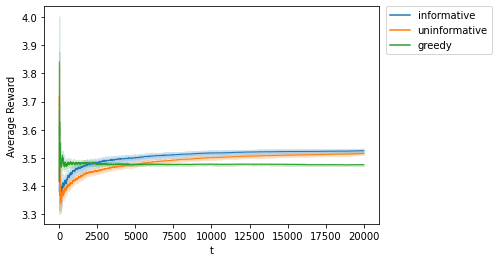

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
result = pd.DataFrame({'rep':np.concatenate([np.ones(T)*rep for rep in range(S)]*3),
                       't':np.concatenate([range(T)]*3*S),
                       'Reward':np.concatenate(cum_reward_informative+cum_reward_uninformative+cum_reward_greedy),
                       'Algo':['informative']*T*S+['uninformative']*T*S+['greedy']*T*S})
sns.lineplot(data=result[result.t>0], x='t', y="Reward", hue="Algo", ci = 95,
             n_boot = 20, linewidth = 1.0, markers = False)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylabel('Average Reward')